# Figure 4B

# Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from sympy import symbols, solve, simplify
import seaborn as sb
import pandas as pd
import sympy as sp
plt.rcParams.update({'font.size': 20})

# Model 

Definition of the parameters of the model

In [2]:
T, V1, V2, K1, K2, Kb = symbols('T V1 V2 K1 K2 Kb') 
Vs, Rb, Ks, Vrg, Qb, Krg = symbols('Vs Rb Ks Vrg Qb Krg')
R, F, Kd, Q, E, Ke = symbols('R F Kd Q E Ke')
S1, Qtot, S2, Rtot= symbols('S1 Qtot S2 Rtot')
Ap,kMM3,Er,KMM3,vMM4,KMM4 = symbols('Ap kMM3 Er KMM3 vMM4 KMM4')
I, kMM1, Er, KMM1, vMM2,KMM2 = symbols('I kMM1 Er KMM1 vMM2 KMM2')
vb, vo, Ap, Ka, Ki, I, k, O = symbols('vb vo Ap Ka Ki I k O')

Evolution equation for T

In [3]:
# Evolution equation for T: 
expr = V1*(1-T)/(K1+(1-T))-V2*T/(K2+T)-Kb*T
expr_simplified= V1*(1-T)*(K2+T) -V2*T*(K1+(1-T))-Kb*T*(K1+(1-T))*(K2+T)
print('Evolution equation for T:')
print(expr)

# Substitute the expression for V1 and V2 in the evolution equation for T:  
expr_RQ= expr_simplified.subs([(V1, Vs*(R*F/(Kd+F))/(Ks+(R*F/(Kd+F)))),(V2, Vrg*(Q*E/(Ke+E))/(Krg+(Q*E/(Ke+E))))])

# Substitute the expressions for Q and R
expr_S1S2 = expr_RQ.subs([(R, Rtot*S1),(Q, Qtot*S2)])

# Expliciting the relation between S1 and S2 to obtain T(FGF, S1): 
expr_T = expr_S1S2.subs([(S2,-1.1265*S1 +0.9092)])

print('Evolution equation for T (all parameters explicited):')
print(expr_T)

# Solve the equation 
sol = solve(expr_T, T)[2]

Evolution equation for T:
-Kb*T - T*V2/(K2 + T) + V1*(1 - T)/(K1 - T + 1)
Evolution equation for T (all parameters explicited):
-E*Qtot*T*Vrg*(0.9092 - 1.1265*S1)*(K1 - T + 1)/((E + Ke)*(E*Qtot*(0.9092 - 1.1265*S1)/(E + Ke) + Krg)) + F*Rtot*S1*Vs*(1 - T)*(K2 + T)/((F + Kd)*(F*Rtot*S1/(F + Kd) + Ks)) - Kb*T*(K2 + T)*(K1 - T + 1)


Definition of the function ExprT that compute T as a function of all the parameters of the equation

In [4]:
def exprT(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5):
    sol_T = sol.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v)])
    sol_T = np.real(np.array(sol_T,complex))
    return sol_T

In [5]:
# Solve the equation 
sol_S1S2 = solve(expr_S1S2, T)[1]

def exprT_S1S2(Vs_v=1, Vrg_v=0.4, K1_v=0.5, K2_v=0.2, Krg_v=1200, Ks_v=1200, Kb_v=0.2, F_v=5, Kd_v=25, E_v=5, Ke_v=50, Rtot_v=2000, Qtot_v=2000, S1_v=0.5, S2_v= 0.4):
    sol_S= sol_S1S2.subs([(Vs,Vs_v),(Vrg,Vrg_v),(K1, K1_v),(K2,K2_v),(Krg, Krg_v), (Ks, Ks_v), (Kb, Kb_v),(F, F_v),(Kd, Kd_v),(E,E_v), (Ke, Ke_v),(Rtot, Rtot_v),(Qtot,Qtot_v),(S1,S1_v),(S2,S2_v)])
    sol_S = np.real(np.array(sol_S,complex))
    return sol_S

Definition of the function to compute Erk (as a function of T)

In [6]:
def Erk(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = [ Erk_max* T[i]**n/(T[i]**n +Kerk**n)+Erk_bas for i in range(len(T)) ]
    return Erk

In [7]:
def Erk1D(T,n=2, Kerk=0.5, Erk_max=1, Erk_bas=0): 
    Erk = Erk_max* T**n/(T**n +Kerk**n) + Erk_bas
    return Erk

Evolution equation for the activator Ap

In [8]:
expr_Ap = kMM3*Er*(1-Ap)/(KMM3+(1-Ap))-vMM4*Ap/(KMM4+Ap)
sol_Ap= solve(expr_Ap, Ap)[1] 

# Function to compute Ap as a function of the other parameters:  
def exprAp(kMM3_v=12,Er_v=0.5,KMM3_v=0.05,vMM4_v=1,KMM4_v=0.05):
    solAp= sol_Ap.subs([(kMM3,kMM3_v), (Er,Er_v), (KMM4,KMM4_v), (vMM4,vMM4_v), (KMM3,KMM3_v)]) 
    return solAp

Evolution equation for the inhibitor I

In [9]:
expr_I = -kMM1*Er*I/(KMM1+I)+vMM2*(1-I)/(KMM2+(1-I))
sol_I= solve(expr_I, I)[0] 

# Function to compute I as a function of the other parameters: 
def exprI(kMM1_v=12,Er_v=0.5,KMM1_v=0.05,vMM2_v=1,KMM2_v=0.05): 
    solI= sol_I.subs([(kMM1,kMM1_v), (Er,Er_v), (KMM1,KMM1_v), (vMM2,vMM2_v), (KMM2,KMM2_v)]) 
    return solI 

Compute Otx and define a function ExprOtx that compute Otx as a function of all the parameters of the equation

In [10]:
expr_Otx = vb+ vo*Ap/((Ka*(1+I/Ki))+Ap)-k*O
sol_Otx= solve(expr_Otx, O)[0]  

# Function to compute Otx as a function of the other parameters
def exprOtx(Ap_v, I_v, vb_v=0.001,vo_v=1,Ka_v=0.1,Ki_v=0.1,k_v=0.2, Omax=1, Obas=0): 
    solOtx= [sol_Otx.subs([(Ap, Ap_v[i]), (I, I_v[i]), (vb,vb_v), (vo,vo_v), (Ka,Ka_v), (Ki,Ki_v), (k,k_v)])*Omax +Obas for i in range(len(Ap_v))] 
    return solOtx

# Import the experimental data

In [11]:
#read the excel file with the experimental data
data_S1 = pd.read_excel('/Users/rossanabettoni/Desktop/PhD/Article_PLOS/ExpData.xlsx', sheet_name='Cell surface contacts')
df_S1 = pd.DataFrame(data_S1)

Cell surface contacts with FGF (S1)

In [12]:
a65_RelContactArea_A = np.array(df_S1['a6.5 S1'].values.tolist())[0:25] 
a66_RelContactArea_A = np.array(df_S1['a6.6 S1'].values.tolist())[0:25] 
a67_RelContactArea_A = np.array(df_S1['a6.7 S1'].values.tolist())[0:25] 
a68_RelContactArea_A = np.array(df_S1['a6.8 S1'].values.tolist())[0:25] 

# Results

## Figure 4B

In [13]:
# Compute T
T_pred_a65 = [exprT(S1_v= a65_RelContactArea_A[i]) for i in range(len(a65_RelContactArea_A))]
T_pred_a66 = [exprT(S1_v= a66_RelContactArea_A[i]) for i in range(len(a66_RelContactArea_A))]
T_pred_a67 = [exprT(S1_v= a67_RelContactArea_A[i]) for i in range(len(a67_RelContactArea_A))]
T_pred_a68 = [exprT(S1_v= a68_RelContactArea_A[i]) for i in range(len(a68_RelContactArea_A))]

# Compute Erk 
Erk_pred_a65 = Erk(T_pred_a65)
Erk_pred_a66 = Erk(T_pred_a66)
Erk_pred_a67 = Erk(T_pred_a67)
Erk_pred_a68 = Erk(T_pred_a68)

# Compute Ap
Ap_pred_a65 = [exprAp(Er_v=Erk_pred_a65[i]) for i in range(len(Erk_pred_a65))]
Ap_pred_a66 = [exprAp(Er_v=Erk_pred_a66[i]) for i in range(len(Erk_pred_a66))]
Ap_pred_a67 = [exprAp(Er_v=Erk_pred_a67[i]) for i in range(len(Erk_pred_a67))]
Ap_pred_a68 = [exprAp(Er_v=Erk_pred_a68[i]) for i in range(len(Erk_pred_a68))]

# Compute I 
I_pred_a65 = [exprI(Er_v=Erk_pred_a65[i]) for i in range(len(Erk_pred_a65))]
I_pred_a66 = [exprI(Er_v=Erk_pred_a66[i]) for i in range(len(Erk_pred_a66))]
I_pred_a67 = [exprI(Er_v=Erk_pred_a67[i]) for i in range(len(Erk_pred_a67))]
I_pred_a68 = [exprI(Er_v=Erk_pred_a68[i]) for i in range(len(Erk_pred_a68))]

# Compute Otx expression
Otx_pred_a65 = np.array(exprOtx(Ap_v=Ap_pred_a65,I_v=I_pred_a65)).astype(float)
Otx_pred_a66 = np.array(exprOtx(Ap_v=Ap_pred_a66,I_v=I_pred_a66)).astype(float)
Otx_pred_a67 = np.array(exprOtx(Ap_v=Ap_pred_a67,I_v=I_pred_a67)).astype(float)
Otx_pred_a68 = np.array(exprOtx(Ap_v=Ap_pred_a68,I_v=I_pred_a68)).astype(float)

# Compute mean
a65_Otx_mean_pred = np.mean(Otx_pred_a65)
a66_Otx_mean_pred = np.mean(Otx_pred_a66)
a67_Otx_mean_pred = np.mean(Otx_pred_a67)
a68_Otx_mean_pred = np.mean(Otx_pred_a68)

# Compute std
a65_Otx_std_pred = np.std(Otx_pred_a65)
a66_Otx_std_pred = np.std(Otx_pred_a66)
a67_Otx_std_pred = np.std(Otx_pred_a67)
a68_Otx_std_pred = np.std(Otx_pred_a68)

mean_Otx_pred = [a65_Otx_mean_pred, a66_Otx_mean_pred, a67_Otx_mean_pred, a68_Otx_mean_pred]
std_Otx_pred = [a65_Otx_std_pred, a66_Otx_std_pred, a67_Otx_std_pred, a68_Otx_std_pred]

Code to find the $S_1^*$ (and $S_2^*$) for which $Otx(S_1^*) = Otx_{mean}[j]$

In [14]:
RelContactArea_A = [a65_RelContactArea_A, a66_RelContactArea_A, a67_RelContactArea_A, a68_RelContactArea_A]
S1_star = np.zeros(4)
Erk_check = np.zeros(4)
Otx_check = np.zeros(4)

for j in range(4): 

    S1_min_exp = min(RelContactArea_A[j]) # Minimum exp value of S1
    S1_max_exp = max(RelContactArea_A[j]) # Maximum exp value of S1

    # Initialization of the variables
    diff = 1  
    S1_lim_min = S1_min_exp
    S1_lim_max = S1_max_exp

    while diff > 0.0000001: 

        S1_test= np.linspace(S1_lim_min,S1_lim_max, 20)

        # Compute Erk for the i-element of S1_temp
        T_test = [exprT(S1_v= S1_test[i]) for i in range(len(S1_test))]
        Erk_test = Erk(T_test)
        
        Ap_test = [exprAp(Er_v=Erk_test[i]) for i in range(len(Erk_test))]
        I_test = [exprI(Er_v=Erk_test[i]) for i in range(len(Erk_test))]        
       
        Otx_test = exprOtx(Ap_v=Ap_test,I_v=I_test)

        # Compute the difference between the ith value of Otx_test and the mean mean_Otx_model
        x = [abs(Otx_test[i]- mean_Otx_pred[j]) for i in range(len(Otx_test))]

        # Find the minimum 
        idx = x.index(min(x))
        S1_star[j] = S1_test[idx]

        diff = abs(mean_Otx_pred[j] - Otx_test[idx])
        Otx_check[j] = Otx_test[idx]

        S1_lim_min = S1_test[idx - 3]
        S1_lim_max = S1_test[idx + 3]

# Compute S2* 
S2_star = [-1.1265*S1_star[i]+0.9092 for i in range(len(S1_star))]

Define the dictionaries to link each parameter name to the corresponding parameter value

In [15]:
# Parameters linked to T
parameter_names = ['Vs_v','Vrg_v','Ks_v','Krg_v','K1_v','K2_v','F_v','E_v','Kd_v','Ke_v','Rtot_v','Qtot_v','S1_v','S2_v','Kb_v']
parameter_values_standard = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,0.5,0.5,0.2]
param = dict(zip(parameter_names,parameter_values_standard))
parameter_values_minus = [np.round(parameter_values_standard[i]- parameter_values_standard[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_plus = [np.round(parameter_values_standard[i]+ parameter_values_standard[i]/5,2) for i in range(len(parameter_values_standard))]

# Parameters linked to Erk 
parameter_names_Erk = ['Kerk']
parameter_values_standard_Erk = [0.5]
param_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
parameter_values_minus_Erk = [np.round(parameter_values_standard_Erk[i]- parameter_values_standard_Erk[i]/5,2) for i in range(len(parameter_values_standard_Erk))]
parameter_values_plus_Erk = [np.round(parameter_values_standard_Erk[i]+ parameter_values_standard_Erk[i]/5,2) for i in range(len(parameter_values_standard_Erk))]

# Parameters linked to Otx
parameter_names_Otx = ['k_v','Ka_v', 'Ki_v', 'vo_v', 'vb_v']
parameter_values_standard_Otx = [0.2, 0.1,0.1, 1, 0.001]
param_Otx = dict(zip(parameter_names_Otx,parameter_values_standard_Otx))
parameter_values_minus_Otx = [parameter_values_standard_Otx[i]- parameter_values_standard_Otx[i]/5 for i in range(len(parameter_values_standard_Otx))]
parameter_values_plus_Otx = [parameter_values_standard_Otx[i]+ parameter_values_standard_Otx[i]/5 for i in range(len(parameter_values_standard_Otx))]

# Define the standard values of the parameters for each cell type
parameter_values_standard_a68 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[3], S2_star[3], 0.2]
parameter_values_standard_a66 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[1], S2_star[1], 0.2]
parameter_values_standard_a67 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[2], S2_star[2], 0.2]
parameter_values_standard_a65 = [1,0.4,1200, 1200, 0.5,0.2,5,5,25,50,2000,2000,S1_star[0], S2_star[0], 0.2]

# Define the standard values of the parameters ± 20% for each cell type
parameter_values_plus_a68 = [np.round(parameter_values_standard_a68[i]+ parameter_values_standard_a68[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_plus_a66 = [np.round(parameter_values_standard_a66[i]+ parameter_values_standard_a66[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_plus_a67 = [np.round(parameter_values_standard_a67[i]+ parameter_values_standard_a67[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_plus_a65 = [np.round(parameter_values_standard_a65[i]+ parameter_values_standard_a65[i]/5,2) for i in range(len(parameter_values_standard))]

parameter_values_minus_a68 = [np.round(parameter_values_standard_a68[i]- parameter_values_standard_a68[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_minus_a66 = [np.round(parameter_values_standard_a66[i]- parameter_values_standard_a66[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_minus_a67 = [np.round(parameter_values_standard_a67[i]- parameter_values_standard_a67[i]/5,2) for i in range(len(parameter_values_standard))]
parameter_values_minus_a65 = [np.round(parameter_values_standard_a65[i]- parameter_values_standard_a65[i]/5,2) for i in range(len(parameter_values_standard))]

parameter_values_standard_Ap = [0.05,0.05,12,1]
parameter_values_standard_I = [0.05,0.05,12,1]

parameter_names_Ap = ['KMM3_v', 'KMM4_v', 'kMM3_v', 'vMM4_v']
param_standard_Ap= dict(zip(parameter_names_Ap,parameter_values_standard_Ap))

parameter_names_I = ['KMM1_v', 'KMM2_v', 'kMM1_v', 'vMM2_v']
param_standard_I= dict(zip(parameter_names_I,parameter_values_standard_I))

### Effect of changing the value of the parameters by ± 20%

Compute level of Otx when parameter values = standard values - 20%

In [16]:
Otx_output_a68_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Otx_output_a66_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Otx_output_a67_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Otx_output_a65_minus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)

# Cell a68
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    param_temp[parameter_names[i]] = parameter_values_minus_a68[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a68_minus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a68_minus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
# Cell a66  
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    param_temp[parameter_names[i]] = parameter_values_minus_a66[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a66_minus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a66_minus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]


# Cell a67
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    param_temp[parameter_names[i]] = parameter_values_minus_a67[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a67_minus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a67_minus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]


# Cell a65
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    param_temp[parameter_names[i]] = parameter_values_minus_a65[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a65_minus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_minus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a65_minus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]

In [17]:
# Compute the output minus 
Otx_output_a68_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Otx_output_a66_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Otx_output_a67_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)
Otx_output_a65_plus = np.zeros(len(parameter_names)+len(parameter_names_Erk)+1)

# Cell a68
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    param_temp[parameter_names[i]] = parameter_values_plus_a68[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a68_plus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a68))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a68_plus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
# Cell a66  
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    param_temp[parameter_names[i]] = parameter_values_plus_a66[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a66_plus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a66))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a66_plus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]


# Cell a67
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    param_temp[parameter_names[i]] = parameter_values_plus_a67[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a67_plus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a67))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a67_plus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]


# Cell a65
for i in range(len(parameter_names)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    param_temp[parameter_names[i]] = parameter_values_plus_a65[i]
    T_pred_S1star = exprT_S1S2(**param_temp)
    Erk_t = Erk1D(T_pred_S1star)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a65_plus[i] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]
    
for i in range(len(parameter_names_Erk)): 
    param_temp = dict(zip(parameter_names,parameter_values_standard_a65))
    T_pred_S1star = exprT_S1S2(**param_temp)
    
    param_temp_Erk = dict(zip(parameter_names_Erk,parameter_values_standard_Erk))
    param_temp_Erk[parameter_names_Erk[i]] = parameter_values_plus_Erk[i]   
    Erk_t = Erk1D(T=T_pred_S1star,**param_temp_Erk)
    
    Ap_pred_Erkstar = [exprAp(Er_v= Erk_t, **param_standard_Ap)]
    I_pred_Erkstar = [exprI(Er_v= Erk_t, **param_standard_I)]
    Otx_output_a65_plus[i+len(parameter_names)] = exprOtx(Ap_v=Ap_pred_Erkstar,I_v=I_pred_Erkstar,**param_Otx)[0]

### Effect of varying the relation between $S_1$ and $S_2$ ($S_2=-a*S_1+b $) on the level of Otx: 
we changed the value of $a$ by $\pm 20 \%$ ($a'=a\pm 20 \%$) and fit the experimental data with the relation $S_2=-a'*S_1+b$ to find the best value for $b$

In [18]:
Otx_output_a68_plus[ len(Otx_output_a68_plus)-1] = 0.01068928640686291
Otx_output_a66_plus[ len(Otx_output_a66_plus)-1] = 0.028335085873956688
Otx_output_a67_plus[ len(Otx_output_a67_plus)-1] = 0.4491873297901298
Otx_output_a65_plus[ len(Otx_output_a67_plus)-1] = 4.348699575244343 

Otx_output_a68_minus[ len(Otx_output_a68_minus)-1] = 0.010309878875177531
Otx_output_a66_minus[ len(Otx_output_a66_minus)-1] = 0.027195188125942037
Otx_output_a67_minus[ len(Otx_output_a67_minus)-1] = 0.48743434347697234
Otx_output_a65_minus[ len(Otx_output_a65_minus)-1] = 4.37375458400932

### Figure

In [19]:
parameter_names_fig = ['$V_s$','$V_{rg}$','$K_s$','$K_{rg}$','$K_1$','$K_2$','[FGF]','[eph]','$K_d$','$K_e$','$R_{tot}$','$Q_{tot}$','$S_1$', '$S_2$','$K_b$', '$K_{erk}$', '$S_2(S_1)$']
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [20]:
# Normalization 
Otx_output_a68_plus_n = [Otx_output_a68_plus[i]/mean_Otx_pred[3] for i in range(len(Otx_output_a68_plus))]
Otx_output_a68_minus_n = [Otx_output_a68_minus[i]/mean_Otx_pred[3] for i in range(len(Otx_output_a68_minus))]

Otx_output_a66_plus_n = [Otx_output_a66_plus[i]/mean_Otx_pred[1] for i in range(len(Otx_output_a66_plus))]
Otx_output_a66_minus_n = [Otx_output_a66_minus[i]/mean_Otx_pred[1] for i in range(len(Otx_output_a66_minus))]

Otx_output_a67_plus_n = [Otx_output_a67_plus[i]/mean_Otx_pred[2] for i in range(len(Otx_output_a67_plus))]
Otx_output_a67_minus_n = [Otx_output_a67_minus[i]/mean_Otx_pred[2] for i in range(len(Otx_output_a67_minus))]

Otx_output_a65_plus_n = [Otx_output_a65_plus[i]/mean_Otx_pred[0] for i in range(len(Otx_output_a65_plus))]
Otx_output_a65_minus_n = [Otx_output_a65_minus[i]/mean_Otx_pred[0] for i in range(len(Otx_output_a65_minus))]


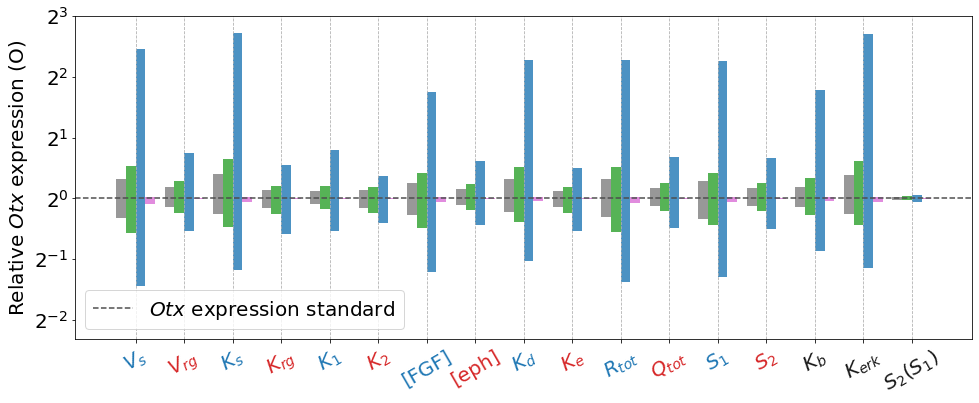

In [21]:
Otx_min_a65_fig = np.zeros(len(Otx_output_a65_minus))
Otx_min_a66_fig = np.zeros(len(Otx_output_a66_minus))
Otx_min_a67_fig = np.zeros(len(Otx_output_a67_minus))
Otx_min_a68_fig = np.zeros(len(Otx_output_a68_minus))

Otx_max_a65_fig = np.zeros(len(Otx_output_a65_minus))
Otx_max_a66_fig = np.zeros(len(Otx_output_a66_minus))
Otx_max_a67_fig = np.zeros(len(Otx_output_a67_minus))
Otx_max_a68_fig = np.zeros(len(Otx_output_a68_minus))

for i in range(len(Otx_output_a68_minus_n)): 
    if  Otx_output_a68_minus_n[i] > Otx_output_a68_plus_n[i]: 
        Otx_max_a68_fig[i] = Otx_output_a68_minus_n[i]
        Otx_min_a68_fig[i] = Otx_output_a68_plus_n[i]
    else:
        Otx_max_a68_fig[i] = Otx_output_a68_plus_n[i]
        Otx_min_a68_fig[i] = Otx_output_a68_minus_n[i]

for i in range(len(Otx_output_a66_minus_n)): 
    if  Otx_output_a66_minus_n[i] > Otx_output_a66_plus_n[i]: 
        Otx_max_a66_fig[i] = Otx_output_a66_minus_n[i]
        Otx_min_a66_fig[i] = Otx_output_a66_plus_n[i]
    else:
        Otx_max_a66_fig[i] = Otx_output_a66_plus_n[i]
        Otx_min_a66_fig[i] = Otx_output_a66_minus_n[i]

for i in range(len(Otx_output_a67_minus_n)): 
    if  Otx_output_a67_minus_n[i] > Otx_output_a67_plus_n[i]: 
        Otx_max_a67_fig[i] = Otx_output_a67_minus_n[i]
        Otx_min_a67_fig[i] = Otx_output_a67_plus_n[i]
    else:
        Otx_max_a67_fig[i] = Otx_output_a67_plus_n[i]
        Otx_min_a67_fig[i] = Otx_output_a67_minus_n[i]
        
for i in range(len(Otx_output_a65_minus_n)): 
    if  Otx_output_a65_minus_n[i] > Otx_output_a65_plus_n[i]: 
        Otx_max_a65_fig[i] = Otx_output_a65_minus_n[i]
        Otx_min_a65_fig[i] = Otx_output_a65_plus_n[i]
    else:
        Otx_max_a65_fig[i] = Otx_output_a65_plus_n[i]
        Otx_min_a65_fig[i] = Otx_output_a65_minus_n[i]
        

# Figure
height_fig_a68 = [Otx_max_a68_fig[i]-Otx_min_a68_fig[i] for i in range(len(Otx_max_a68_fig))]
bottom_fig_a68 = [Otx_min_a68_fig[i] for i in range(len(Otx_min_a68_fig))]

height_fig_a66 = [Otx_max_a66_fig[i]-Otx_min_a66_fig[i] for i in range(len(Otx_max_a66_fig))]
bottom_fig_a66 = [Otx_min_a66_fig[i] for i in range(len(Otx_min_a66_fig))]

height_fig_a67 = [Otx_max_a67_fig[i]-Otx_min_a67_fig[i] for i in range(len(Otx_max_a67_fig))]
bottom_fig_a67 = [Otx_min_a67_fig[i] for i in range(len(Otx_min_a67_fig))]

height_fig_a65 = [Otx_max_a65_fig[i]-Otx_min_a65_fig[i] for i in range(len(Otx_max_a65_fig))]
bottom_fig_a65 = [Otx_min_a65_fig[i] for i in range(len(Otx_min_a65_fig))]

x_new = 2.5*x

plt.figure(figsize=(14,6))

plt.bar(x_new-0.75,height_fig_a68, width=0.5, bottom=bottom_fig_a68, color='tab:grey' , alpha=0.8)
plt.bar(x_new-0.25,height_fig_a66, width=0.5, bottom=bottom_fig_a66, color='tab:green', alpha=0.8 )
plt.bar(x_new+0.25,height_fig_a67, width=0.5, bottom=bottom_fig_a67, color='tab:blue', alpha=0.8 )
plt.bar(x_new+0.75,height_fig_a65, width=0.5, bottom=bottom_fig_a65, color='orchid', alpha=0.8 )

plt.axhline(y=1,linestyle='--',linewidth=1.5, color='0.3', label='$Otx$ expression standard')
plt.ylabel('Relative $Otx$ expression (O)')
plt.xticks(x_new, parameter_names_fig, color='tab:red', rotation=30)

for i in [0,2,4,6,8,10,12]:
    plt.gca().get_xticklabels()[i].set_color('tab:blue') 
    
for i in [14,15,16]:
    plt.gca().get_xticklabels()[i].set_color('0.1') 

plt.legend()
plt.yscale('log',base=2)
plt.ylim([0.2, 8])
plt.gca().xaxis.grid(True, linestyle='dashed')
plt.tight_layout()
plt.savefig('SensitivityAnalysis_Otx_Erkparams.png')
plt.show()